# Transfer Learning

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
x_train = train_dataset["train_set_x"][:]
y_train = train_dataset["train_set_y"][:]

test_dataset = h5py.File('test_catvnoncat.h5', "r")
x_test = test_dataset["test_set_x"][:]
y_test = test_dataset["test_set_y"][:]

In [3]:
X_train = np.array(x_train, dtype='float32')
Y_train = np.reshape(np.array(y_train, dtype='float32'),(-1,1))

X_test = np.array(x_test, dtype='float32') 
Y_test = np.reshape(np.array(y_test, dtype='float32'),(-1,1))

It's not a cat!


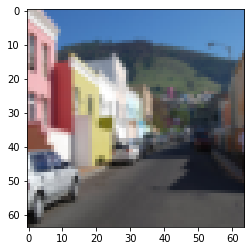

In [4]:
index = 1
plt.imshow(X_train[index].astype(dtype='int32'))
print("It's{} a cat!".format((1-Y_train[index,0].astype(dtype='int32'))*' not'))

In [5]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet',
                                    include_top=True)
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
def Model(params):
    dims = params['dims']
    X_train = params['X_train']
    Y_train = params['Y_train']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    threshold = params['threshold']
    transfer_model = params['transfer_model']
    trainable = params['trainable']
    x = tf.keras.Input(shape=dims[0])
    y = x
    for layer in transfer_model.layers[1:-4]:
        layer_ = layer.__class__.from_config(layer.get_config())
        y = layer_(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(units=256, 
                              activation='relu', 
                              kernel_initializer='glorot_uniform', 
                              bias_initializer='zeros', 
                              name='fc1')(y)
    y = tf.keras.layers.Dense(units=256, 
                              activation='relu', 
                              kernel_initializer='glorot_uniform', 
                              bias_initializer='zeros', 
                              name='fc2')(y)
    y = tf.keras.layers.Dense(units=dims[-1], 
                              activation='sigmoid', 
                              kernel_initializer='glorot_uniform', 
                              bias_initializer='zeros', 
                              name='predictions')(y)       
    model = tf.keras.Model(x, y)  
    for layer in transfer_model.layers[1:-4]:
        layer_ = model.get_layer(name=layer.name)
        layer_.set_weights(layer.get_weights())
        layer_.trainable = trainable
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)    
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)    
    model.summary()
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
    return model

In [7]:
model = Model({'dims':[X_train.shape[1:], Y_train.shape[1]], 
               'X_train':X_train,
               'Y_train':Y_train,
               'epochs':10, 
               'learning_rate':0.01,
               'batch_size':32,
               'threshold':0.5,
               'transfer_model':vgg19, 
               'trainable':False})

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [8]:
model.evaluate(X_train, Y_train)

209/209 [==============================] - 3s 14ms/sample - loss: 1.6512e-05 - binary_accuracy: 1.0000


[1.6511592602446676e-05, 1.0]

In [9]:
model.evaluate(X_test, Y_test)

50/50 [==============================] - 1s 13ms/sample - loss: 2.8390 - binary_accuracy: 0.9200


[2.838978157043457, 0.92]

It's a cat!


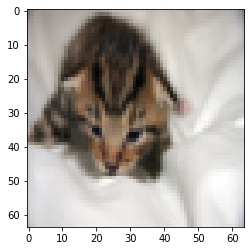

In [10]:
index = 1
plt.imshow(np.reshape(X_test[index,:].astype('int32'), (64,64,3)))
print("It's{} a cat!".format((1-(model.predict(X_test[[index],:,:,:])[0,0]>0.5).astype(int))*' not'))

It's a cat!


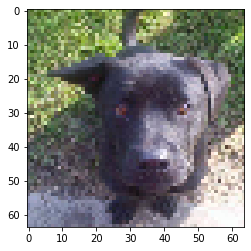

In [11]:
img = np.array(plt.imread("dog.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_,axis=0)
print("It's{} a cat!".format((1-(model.predict(img__)[0,0]>0.5).astype(int))*' not'))